# Exercise 1:  Convolutional Autoencoder
Train a convolutional autoencoder on MNIST, study the influence of the bottleneck size and generate some images


## Importing libraries and packages



In [0]:
import numpy as np
SEED = 64
np.random.seed(SEED)
import torch
import torch.optim as optim
torch.manual_seed(SEED)
if torch.cuda.is_available():
  torch.cuda.manual_seed_all(SEED)
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from timeit import default_timer as timer
import random
random.seed(SEED)
from random import shuffle

# To split training data to train and validation. Uses SubsetRandomSampler to shuffle indices
from torch.utils.data.sampler import SubsetRandomSampler 

## Defining the Hyper-parameters

In [0]:
# Let's define some hyper-parameters
hparams = {
    'batch_size':64,
    'num_epochs':10,
    'test_batch_size':64,
    'hidden_size':128,
    'num_classes':10,
    'num_inputs':784,
    'learning_rate':1e-3,
    'log_interval':100,
    'valid_size': 0.05, # percentage split of the training set used for the validation set.
}

# we select to work on GPU if it is available in the machine, otherwise
# will run on CPU
hparams['device'] = 'cuda' if torch.cuda.is_available() else 'cpu'

## Loading data

Note: The values 0.1307 and 0.3081 used for the Normalize() transformation below are the global mean and standard deviation of the MNIST dataset, we'll take them as a given here.

In [0]:
mnist_trainset = datasets.MNIST('data', train=True, download=True,
                                transform=transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.1307,), (0.3081,))
                                ]))
mnist_testset = datasets.MNIST('data', train=False, 
                               transform=transforms.Compose([
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.1307,), (0.3081,))
                               ]))


Split the original training data into 95% training and 5% validation data.

In [0]:
num_train = len(mnist_trainset)
indices = list(range(num_train))
split = int(np.floor(hparams['valid_size'] * num_train))

if shuffle == True:
  np.random.seed(random_seed)
  np.random.shuffle(indices)

train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)


train_loader = torch.utils.data.DataLoader(
    mnist_trainset,
    batch_size=hparams['batch_size'], 
    sampler=train_sampler)

valid_loader = torch.utils.data.DataLoader(
    mnist_trainset,
    batch_size=hparams['batch_size'], 
    sampler=valid_sampler)

test_loader = torch.utils.data.DataLoader(
    mnist_testset,
    batch_size=hparams['test_batch_size'], 
    shuffle=False)

## Visualize the Data

Now let's take a look at some examples. We'll use the test_loader for this.

In [0]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

Ok let's see what one test data batch consists of.

In [0]:
example_data.shape

torch.Size([64, 1, 28, 28])

So one test data batch is a  tensor of shape: Vector(4) [64, 1, 28,28]. This means we have *test_batch_size* examples of 28x28 pixels in grayscale (i.e. no rgb channels, hence the one). We can plot some of them using matplotlib.


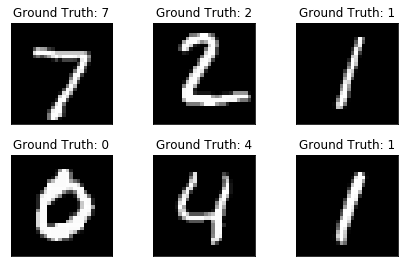

In [0]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([]) # No ticks in x axis
  plt.yticks([]) # No ticks in y axis

## Encoder
Input data is passed through an encoder
Input images are 28x28x1 in size. These images will be passed through encoder layers

Encoder will compress the input.

It will have convolutional layers followed by max pooling layer to reduce dimensions to 7x7x4


**Note:**

> *nn.Conv2d(in_channels, out_channels/number of filters (k), kernel_size (K), stride (S) = 1, padding (P) = 0)*

> Input volume size  W1 x W1 x D1

> Output volume size W2 x W2 x D2

> W2 = (W1 - F + 2P) / S + 1

> D2 = K

In [0]:
class ConvEncoder(nn.Module):
  def __init__(self):
    super().__init__()
    
    self.encoder = nn.Sequential(
        # conv layer (depth from 1 --> 16), 3x3 kernels
        nn.Conv2d(1, 16, 3, stride=3, padding=1),  # 10 x 10 x 16
        nn.ReLU(True),
        
        # pooling layer to reduce x-y dims by two; kernel and stride of 2
        nn.MaxPool2d(2, stride=2),  # 5 x 5 x 16
        
        # conv layer (depth from 16 --> 4), 3x3 kernels
        nn.Conv2d(16, 8, 3, padding=1),  # 4 x 4 x 8
        nn.ReLU(True),
        
        # pooling layer to reduce x-y dims by two; kernel and stride of 2
        nn.MaxPool2d(2, 2)  # 2 x 2 x 8
    )
    
    def forward(self, x):
      return self.encoder(x)

# Print model
print(ConvEncoder())

ConvEncoder(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
)


## Decoder
Compressed data is is passed through a decoder to reconstruct the input data

This layer will bring back to original dimension 28x28x1

Will use transposed convolutional layers to increase width and height of compressed input

Transpose convolution layers can lead to artifacts in the final images, such as checkerboard patterns. This is due to overlap in the kernels which can be avoided by setting the stride and kernel size equal. so we will be using stride = 2 and kernel_size=2

In [0]:
class ConvDecoder(nn.Module):
  def __init__(self):
    super().__init__()
    
    self.decoder = nn.Sequential(
        nn.ConvTranspose2d(8, 16, 3, stride=2),  # 5 x 5 x 16
        nn.ReLU(True),
        nn.ConvTranspose2d(16, 8, 5, stride=3, padding=1),  # 15 x 15 x 8
        nn.ReLU(True),
        nn.ConvTranspose2d(8, 1, 2, stride=2, padding=1),  # 28 x 28 x 1
        nn.Tanh()
    )
    
    def forward(self, x):
      return self.decoder(x)

# Print decoder
print(ConvDecoder())

ConvDecoder(
  (decoder): Sequential(
    (0): ConvTranspose2d(8, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(16, 8, kernel_size=(5, 5), stride=(3, 3), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(8, 1, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1))
    (5): Tanh()
  )
)


### Questions

Do we need ReLU in the decoder between layers??

The last activation function, sigmoid? Sigmoid? Because images from this dataset are already normalized between 0 and 1, we need to use a sigmoid activation on the output layer to get values that match this input value range??

Full connected layer after?

## Convolutional Autoencoder

In [0]:
class ConvolutionalAutoencoder(torch.nn.Module):

    def __init__(self):
        super().__init__()

        self.encoder = ConvEncoder()
        self.decoder = ConvDecoder()

    def forward(self, x):
        code = self.encoder.encoder(x)
        reconstruction = self.decoder.decoder(code)

        return reconstruction


model = ConvolutionalAutoencoder() # .cuda() if cude available
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=hparams['learning_rate'],
                             weight_decay=1e-5)

## Train


In [0]:
# Loss function
criterion = nn.MSELoss()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 20
for e in range(1, epochs+1):
    train_loss = 0.0  # monitor training loss
    
    ###################
    # train the model #
    ###################
    for data in train_loader:
        images, _ = data                        # we are just intrested in just images
        # no need to flatten images
        optimizer.zero_grad()                   # clear the gradients
        outputs = model(images)                 # forward pass: compute predicted outputs 
        loss = criterion(outputs, images)       # calculate the loss
        loss.backward()                         # backward pass
        optimizer.step()                        # perform optimization step
        train_loss += loss.item()*images.size(0)# update running training loss
            
    # print avg training statistics 
    train_loss = train_loss/len(train_loader)
    print('Epoch: {}'.format(e),
          '\tTraining Loss: {:.4f}'.format(train_loss))

Epoch: 1 	Training Loss: 39.6967
Epoch: 2 	Training Loss: 32.1005
Epoch: 3 	Training Loss: 31.0645
Epoch: 4 	Training Loss: 30.5898
Epoch: 5 	Training Loss: 30.2971
Epoch: 6 	Training Loss: 30.0720
Epoch: 7 	Training Loss: 29.9043
Epoch: 8 	Training Loss: 29.7761
Epoch: 9 	Training Loss: 29.6697
Epoch: 10 	Training Loss: 29.5800
Epoch: 11 	Training Loss: 29.5053
Epoch: 12 	Training Loss: 29.4289
Epoch: 13 	Training Loss: 29.3479
Epoch: 14 	Training Loss: 29.2754
Epoch: 15 	Training Loss: 29.2055
Epoch: 16 	Training Loss: 29.1422
Epoch: 17 	Training Loss: 29.0731
Epoch: 18 	Training Loss: 29.0275
Epoch: 19 	Training Loss: 28.9839
Epoch: 20 	Training Loss: 28.9401


## Comparing inputs before encoding and output after decoding
Below we can notice that ouput edges are not smooth like in inputs. This is due to checkerboard effect that will happen with transpose layers


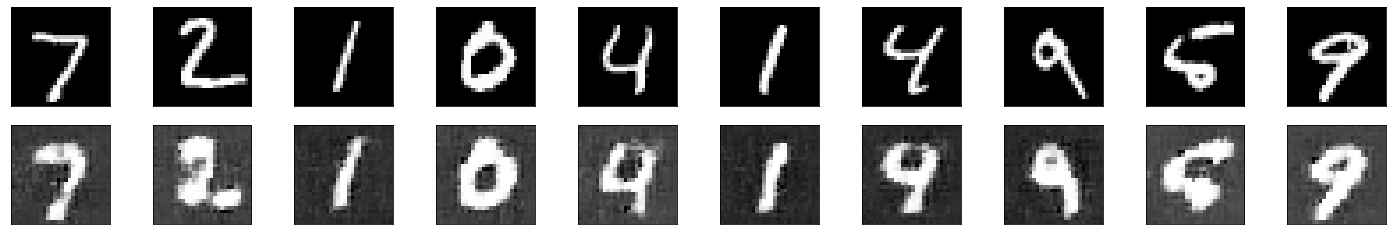

In [0]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

output = model(images)                                      # get sample outputs
images = images.numpy()                                     # prep images for display
output = output.view(hparams['test_batch_size'], 1, 28, 28) # resizing output
output = output.detach().numpy()                            # use detach when it's an output that requires_grad

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))
# input images on top row, reconstructions on bottom
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)


## Exercise 2:  Transfer Learning


## Optional exercise A: Variational Autoencoder

## Optional exercise B: Conditional GAN

## Bibliography/Inspiration
Plot MNIST:
*   https://nextjournal.com/gkoehler/pytorch-mnist


Split train in train and validation: 
*   https://gist.github.com/MattKleinsmith/5226a94bad5dd12ed0b871aed98cb123


Encoder and decoder: 
*   https://github.com/L1aoXingyu/pytorch-beginner/blob/master/08-AutoEncoder/conv_autoencoder.py
*   https://github.com/ShashiChilukuri/Deep-Learning-Projects/blob/master/CNN(PyTorch)%20-%20MNIST%20Convolutional%20Autoencoder/CNN(PyTorch)%20-%20MNIST%20Transpose%20Convolutional%20Autoencoder.ipynb






---



---


Per mirar:


https://github.com/ReyhaneAskari/pytorch_experiments/blob/master/AE.py
https://github.com/L1aoXingyu/pytorch-beginner/blob/master/08-AutoEncoder/conv_autoencoder.py
https://reyhaneaskari.github.io/AE.htm
https://necromuralist.github.io/In-Too-Deep/posts/nano/autoencoders/convolutional-autoencoder/
https://medium.com/analytics-vidhya/dimension-manipulation-using-autoencoder-in-pytorch-on-mnist-dataset-7454578b018
https://medium.com/@vaibhaw.vipul/building-autoencoder-in-pytorch-34052d1d280c
https://gist.github.com/okiriza/16ec1f29f5dd7b6d822a0a3f2af39274